In [1]:
%reset
import torch
import torch.nn as nn
from torchvision import models
from collections import defaultdict
import torch.nn.functional as F
from utils.loss import dice_loss

from utils.dataloader import *
from utils.ply import *
from utils.models import *

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import utils.alienlab as alien
import numpy as np
import utils.vox_to_coord as vtc
import json
from PIL import Image
import imageio

import glob
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    

torch.cuda.get_device_properties(device).total_memory/1e9
torch.cuda.memory_allocated(device)/1e9

cuda:0


0.0

# Load model

In [3]:
if True: 
    model = torch.load('model_weights/trained_model.pt') #needs utils.models imported
    
torch.cuda.memory_allocated(device)/1e9

0.249205248

# Load images

In [4]:
trans_reshape = transforms.Compose([
    #transforms.Resize((448,896)),
    transforms.CenterCrop((896, 448)),
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

Brec = 1 #batch number
i = 4 #plant index
N_cam = 72

 #image path of one plant (N_cam views) and labels
image_paths = np.sort(glob.glob("data/arabidopsis/train/images/*.png"))[N_cam*i:N_cam*(i+1)]
target_paths = np.sort(glob.glob("data/arabidopsis/train/labels/*.png"))[N_cam*i:N_cam*(i+1)]

reconstruction_dataset = CustomDataset(image_paths, target_paths, transform = trans_reshape) #dataloader
reconstruction_loader = torch.utils.data.DataLoader(reconstruction_dataset, batch_size=Brec, shuffle=False, num_workers=1)

print(torch.cuda.memory_allocated(device)/1e9)

0.249205248


# Evaluate images

In [5]:
# Prediction
def evaluate(inputs):

    with torch.no_grad():
        inputs.requires_grad = False
        # Get the first batch
        inputs = inputs.to(device)

        pred = model(inputs)
        # The loss functions include the sigmoid function.
        pred = F.sigmoid(pred)
        
    return pred

model.eval()

pred_tot = []
for inputs, labels in reconstruction_loader: #Predict from dataloader
    pred = evaluate(inputs)
    pred_tot.append(pred) 
    
pred_tot = torch.cat(pred_tot, dim = 0) #All predictions into one tensor


/home/alienor/Documents/Segmentation/segmentation/lib/python3.7/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Adapt predictions to reprojection

In [8]:
def adjust_predictions(preds):
    '''
    The predictions have to be flattened to be accessed by the coordinates tensor. 
    Also a new class has to be added to 
    describe the voxels prohjecting outside the image. 
    These voxels will project onto the last element of the flattened predictions
    that correspond to "pixel outside the image" class.
    Input: predictions in shape (N_cam, W, H, num_labels) torch tensor
    Output: Flattened predictions (N_cam * W * H + 1, num_labels + 1)
    '''
    outside_proj_label = (preds[:,:,:,0]*0).unsqueeze(-1)
    preds = torch.cat([preds, outside_proj_label], dim = 3) #Add a label class: voxel projects outside image
    preds_flat = torch.flatten(preds, end_dim = -2) #Flatten the predictions
    
    outside_label = preds_flat[0] * 0
    outside_label[-1] = 1 
    outside_label = outside_label.unsqueeze(0)
    preds_flat = torch.cat([preds_flat, outside_label]) #Add a last prediction where all 
    #voxels that project outside the  image will collect their class
    
    return preds_flat

#PARAMETERS
Sx = 896 #Center crop
Sy = 448
xinit = 1080 #Original image size
yinit = 1920
label_num = 6

In [9]:
pred_pad = torch.zeros((N_cam, label_num, xinit, yinit))
pred_pad[:,:,(xinit-Sx)//2:(xinit+Sx)//2,(yinit-Sy)//2:(yinit+Sy)//2] = pred_tot #To fit the camera parameters
pred_pad = pred_pad.permute(0,2,3,1)

preds_flat = adjust_predictions(pred_pad)

# Coordinates of the voxels

In [10]:
xy_full_flat = torch.load('voxel_coord/coordinates_05.pt').to(device)

assign_preds = preds_flat[xy_full_flat].reshape(pred_pad.shape[0], 
                                                xy_full_flat.shape[0]//pred_pad.shape[0], preds_flat.shape[-1])
del xy_full_flat

# Preliminary test with sum and threshold


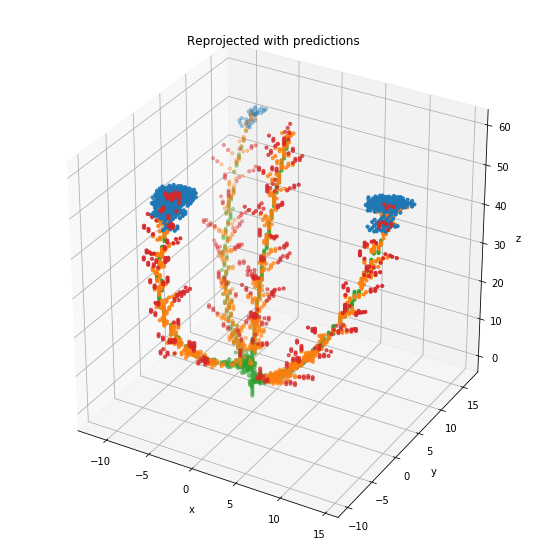

In [11]:
all_views_preds = torch.sum(assign_preds, dim = 0)

vol = torch.load('voxel_coord/voxels_05.pt').to(device)


colors = ['r.', 'k.', 'g.', 'b.']

fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_aspect('equal')
ax.set_title('Reprojected with predictions')


i = 0
for labl in [1,2,3,5]:

    vol[:,3] = all_views_preds[:,labl]

    points = vol[vol[:,3] > 30, :]
    points[:,3] = labl
    points = points.cpu()
    ax.scatter3D(points[:,0], points[:,1], points[:,2], colors[i], s=10)
    i += 1

